## Importing important libraries

In [1]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import nibabel as nib #for loading nii files
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

## Reading the metadata

## Defining function for readiing .nii files

In [3]:
def support_nii(filepath):
#     Reads .nii file and returns pixel array
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [4]:
ct_path="/Users/nikhil/Downloads/ASH_MODEL/ct_scans"
lung_path = "/Users/nikhil/Downloads/ASH_MODEL/lung_mask"
infection_mask = "/Users/nikhil/Downloads/ASH_MODEL/infection_mask"

## Reading the chest ct scan data

In [5]:
# Read sample
sample_ct   = support_nii("/Users/nikhil/Downloads/ASH_MODEL/ct_scans/coronacases_org_001.nii")
sample_lung = support_nii('/Users/nikhil/Downloads/ASH_MODEL/lung_mask/coronacases_001.nii')
sample_infe = support_nii('/Users/nikhil/Downloads/ASH_MODEL/infection_mask/coronacases_001.nii')                                  

## Plotting the sample images

Text(0.5, 1.0, 'Infection Mask')

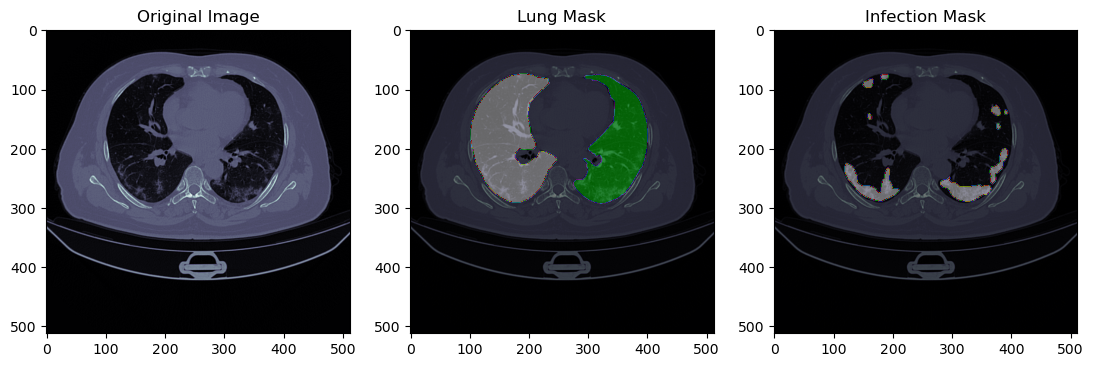

In [6]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

In [7]:
data = pd.read_csv('/Users/nikhil/Downloads/ASH_MODEL/metadata (2).csv')

In [8]:
data.shape

(20, 4)

## Preprocessing


In [9]:
lungs = []
infections = []
img_size = 128

for i in range(len(data)):
    ct = support_nii(data['ct_scan'][i])
    infect = support_nii(data['infection_mask'][i])
    
    for j in range(ct.shape[0]):
        lung_img = cv2.resize(ct[j], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        infec_img = cv2.resize(infect[j],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])

In [10]:
lungs = np.array(lungs)
infections = np.array(infections)

## Performing test and train split

In [31]:
from sklearn.model_selection import train_test_split
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size = 0.4)

## Building the U-Net architecture for the segmentation

In [34]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 lambda_12 (Lambda)          (None, 128, 128, 1)          0         ['input_13[0][0]']            
                                                                                                  
 conv2d_220 (Conv2D)         (None, 128, 128, 16)         160       ['lambda_12[0][0]']           
                                                                                                  
 dropout_104 (Dropout)       (None, 128, 128, 16)         0         ['conv2d_220[0][0]']          
                                                                                           

## Training the model

In [35]:
history = model.fit(lung_train, infect_train, epochs = 8, validation_data = (lung_test, infect_test))

Epoch 1/8
210/210 [==============================] - 225s 1s/step - loss: 0.0620 - accuracy: 0.9887 - val_loss: 0.0353 - val_accuracy: 0.9928
Epoch 2/8
210/210 [==============================] - 219s 1s/step - loss: 0.0262 - accuracy: 0.9931 - val_loss: 0.0235 - val_accuracy: 0.9928
Epoch 3/8
210/210 [==============================] - 213s 1s/step - loss: 0.0188 - accuracy: 0.9937 - val_loss: 0.0156 - val_accuracy: 0.9944
Epoch 4/8
210/210 [==============================] - 227s 1s/step - loss: 0.0129 - accuracy: 0.9953 - val_loss: 0.0127 - val_accuracy: 0.9953
Epoch 5/8
210/210 [==============================] - 221s 1s/step - loss: 0.0111 - accuracy: 0.9958 - val_loss: 0.0107 - val_accuracy: 0.9959
Epoch 6/8
210/210 [==============================] - 218s 1s/step - loss: 0.0097 - accuracy: 0.9962 - val_loss: 0.0094 - val_accuracy: 0.9962
Epoch 7/8
210/210 [==============================] - 205s 976ms/step - loss: 0.0090 - accuracy: 0.9964 - val_loss: 0.0090 - val_accuracy: 0.9964
Epo

## Plotting the performance metrics

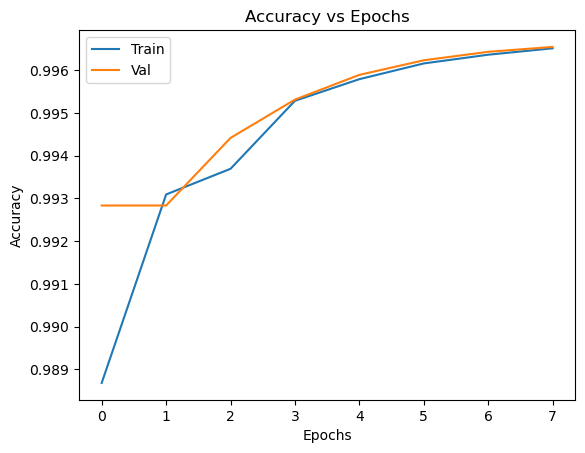

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

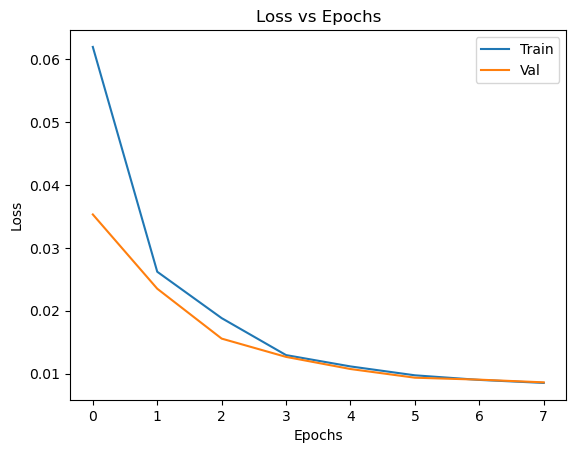

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

## Using our trained model for prediction

140/140 [==============================] - 33s 233ms/step


Text(0.5, 1.0, 'predicted infection mask')

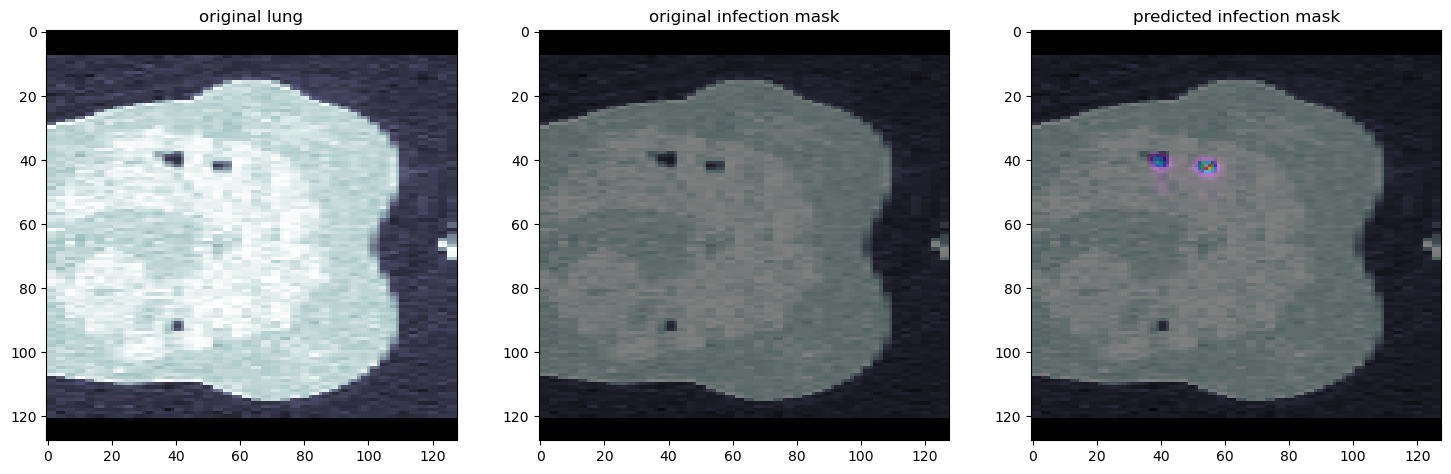

In [38]:
predicted = model.predict(lung_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(lung_test[100][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
plt.imshow(lung_test[100][...,0], cmap = 'bone')
plt.imshow(infect_test[100][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(lung_test[100][...,0], cmap = 'bone')
plt.imshow(predicted[100][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')